# Sentiment Analysis

## Downloading data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shauryadusht","key":"476716826f7e2254f8f688ee7f3dffb2"}'}

In [ ]:
import os
import zipfile

# Make a hidden .kaggle folder and move the key there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other


In [ ]:
with zipfile.ZipFile("sentiment140.zip", 'r') as zip_ref:
    zip_ref.extractall("sentiment140_data")

In [ ]:
os.rename("sentiment140_data/training.1600000.processed.noemoticon.csv", "data.csv")

## Setup and Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import time

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

print("Setup complete!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Setup complete!


## Exploring the Dataset

```
The dataset has 6 fields and 1,600,000 rows
Fields are : sentiment, id, date, query, user, text
Sentiment = 0 --> negative
Sentiment = 4 --> positive
```

In [ ]:
columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df = pd.read_csv('data.csv', encoding='latin-1', names=columns)

In [ ]:
# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

Dataset shape: (1600000, 6)

First few rows:
   sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64


In [ ]:
# sentiment labels from 0/4 to 0/1
df['sentiment'] = df['sentiment'].replace(4, 1)

## Data Visualization

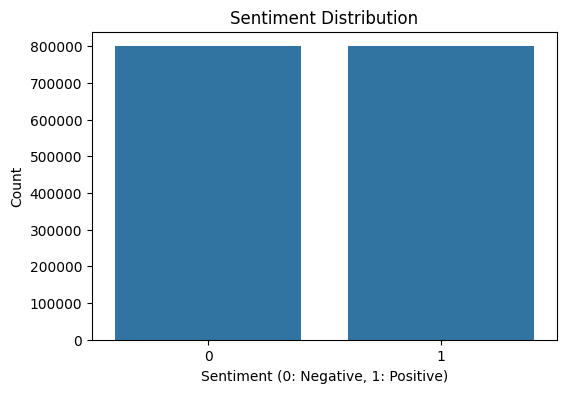

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

In [ ]:
sample_size = 1600000
df_sample = df.sample(sample_size, random_state=42)
print(f"Working with a sample of {sample_size} tweets")

Working with a sample of 1600000 tweets


## Text Preprocessing

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])

    # Apply stemming
    stemmer = PorterStemmer()
    words = text.split()
    text = ' '.join([stemmer.stem(word) for word in words])

    return text

# Apply preprocessing to the text column
df_sample['processed_text'] = df_sample['text'].apply(preprocess_text)
# Display sample preprocessed texts
print("\nSample processed texts:")
for i in range(5):
    print(f"Original: {df_sample['text'].iloc[i]}")
    print(f"Processed: {df_sample['processed_text'].iloc[i]}")
    print()


Sample processed texts:
Original: @chrishasboobs AHHH I HOPE YOUR OK!!! 
Processed: ahhh hope ok

Original: @misstoriblack cool , i have no tweet apps  for my razr 2
Processed: cool tweet app razr

Original: @TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
Processed: know famili drama lamehey next time u hang kim n u guy like sleepov whatev ill call u

Original: School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
Processed: school email wont open geographi stuff revis stupid school

Original: upper airways problem 
Processed: upper airway problem



## Data Splitting

In [ ]:
X = df_sample['processed_text']
y = df_sample['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 1280000
Testing set size: 320000


## Feature Extraction

In [ ]:
%%time

print("Extracting features using TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Feature matrix shape: {X_train_tfidf.shape}")

Extracting features using TF-IDF...
Feature matrix shape: (1280000, 20000)
CPU times: user 19.7 s, sys: 543 ms, total: 20.2 s
Wall time: 36.7 s


## Model Training

In [ ]:
%%time

print("Training Logistic Regression model...")
start_time = time.time()
lr_model = LogisticRegression(max_iter=2000, n_jobs=-1)
lr_model.fit(X_train_tfidf, y_train)

Training Logistic Regression model...
CPU times: user 118 ms, sys: 172 ms, total: 290 ms
Wall time: 11.8 s


LogisticRegression(max_iter=2000, n_jobs=-1)

## Model Evaluation

In [ ]:
y_pred = lr_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7767


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    160000
           1       0.77      0.80      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



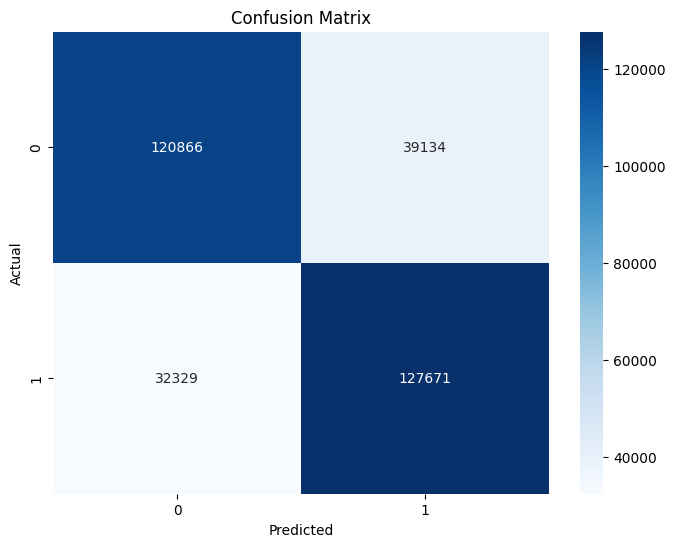

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Save model

In [ ]:
import pickle
from google.colab import files

with open('sentiment_lr_model.pkl', 'wb') as model_file:
    pickle.dump(lr_model, model_file)

with open('sentiment_tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

print("Model and vectorizer saved to disk.")

files.download('sentiment_lr_model.pkl')
files.download('sentiment_tfidf_vectorizer.pkl')

Model and vectorizer saved to disk.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Fine Tuning Using BERT

## Transfer Learning with BERT

In [ ]:
%%capture

!pip install transformers datasets

import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch

In [ ]:
# Load the dataset
columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df = pd.read_csv('data.csv', encoding='latin-1', names=columns)

# Convert sentiment labels from 0/4 to 0/1
df['sentiment'] = df['sentiment'].replace(4, 1)

# Sample a smaller portion for quicker processing
sample_size = 1600000
df_sample = df.sample(sample_size, random_state=42)

# Split the data
train_df, test_df = train_test_split(df_sample, test_size=0.2, random_state=42, stratify=df_sample['sentiment'])

## Prepare the Data for BERT

In [ ]:
%%time

# Convert dataframes to Hugging Face datasets
train_df = train_df.rename(columns={'sentiment': 'labels'})
test_df = test_df.rename(columns={'sentiment': 'labels'})

train_dataset = Dataset.from_pandas(train_df[['text', 'labels']])
test_dataset = Dataset.from_pandas(test_df[['text', 'labels']])

# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Define tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1280000 [00:00<?, ? examples/s]

Map:   0%|          | 0/320000 [00:00<?, ? examples/s]

CPU times: user 5min, sys: 3.58 s, total: 5min 4s
Wall time: 5min


## Fine-tune the Model

In [ ]:
%%time

# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    disable_tqdm=False
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

# Train the model
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.416200,0.375526
2,0.294000,0.391364
3,0.149700,0.577080


CPU times: user 45min 43s, sys: 13.2 s, total: 45min 57s
Wall time: 48min 26s


TrainOutput(global_step=15000, training_loss=0.2929670789162318, metrics={'train_runtime': 2904.3349, 'train_samples_per_second': 82.635, 'train_steps_per_second': 5.165, 'total_flos': 7948043919360000.0, 'train_loss': 0.2929670789162318, 'epoch': 3.0})

## Evaluate the model

In [49]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Get predictions
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)

Evaluation results: {'eval_loss': 0.3755263686180115, 'eval_runtime': 75.2421, 'eval_samples_per_second': 265.809, 'eval_steps_per_second': 4.16, 'epoch': 3.0}


In [50]:
test_df.head()

,labels,id,date,query,user,text
560916,0,2205298063,Wed Jun 17 04:25:42 PDT 2009,NO_QUERY,rpd95,"@aliyoopah shet! you guys, too?? I miss ms. pr..."
1166841,1,1979996874,Sun May 31 05:18:58 PDT 2009,NO_QUERY,anja_heymoon,11 days and my dream comes true. I wanted this...
628303,0,2231244254,Thu Jun 18 18:14:31 PDT 2009,NO_QUERY,bwoods2009,@ the shop today!!! WTF?!? Who wants to sit in...
1316782,1,2014190242,Wed Jun 03 00:44:02 PDT 2009,NO_QUERY,BSBSavedMyLife,@kevinsangel Thanks!
116573,0,1827477292,Sun May 17 10:47:37 PDT 2009,NO_QUERY,emilyessex,Oh and I also found a large bald patch on my h...


In [51]:
# classification report
print(classification_report(test_df['labels'], preds))
print(f"Accuracy: {accuracy_score(test_df['labels'], preds):.4f}")

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      9989
           1       0.86      0.80      0.83     10011

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000

Accuracy: 0.8327


## downlaod the fine tuned model

In [53]:
import shutil

shutil.make_archive('/content/fine_tuned_lr_model', 'zip', '/content/fine_tuned_lr_model')

'/content/fine_tuned_lr_model.zip'

In [54]:
files.download('/content/fine_tuned_lr_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Size of model

In [55]:
!du -sh /content/fine_tuned_lr_model

256M	/content/fine_tuned_lr_model


In [56]:
!du -sh /content/sentiment_lr_model.pkl

160K	/content/sentiment_lr_model.pkl


In [57]:
!du -sh /content/sentiment_tfdf_vectorizer.pkl

du: cannot access '/content/sentiment_tfdf_vectorizer.pkl': No such file or directory
